In [1]:
import pandas as pd
import numpy as np
import math

# 0. 데이터셋 골격이 될 교통사고격자 파일 불러오기
osanAccident = pd.read_csv('ETL_DATA/어린이교통사고_오산시.csv',encoding='CP949')
osanAccident = osanAccident.rename({'val':'acc_sum','long1':'lon1','long2':'lon2'}, axis='columns') 

osanAccident_select = pd.DataFrame(osanAccident , columns=['lon1','lat1','lon2','lat2'])
AccidentList = osanAccident_select.values.tolist()

# 1. 라벨링 및 위치 데이터 설정
#결측치를 0으로 변경해준다.
accidentCnt_select = pd.DataFrame(osanAccident, columns=['lon1','lat1','lon2','lat2','acc_sum'])
accidentCnt_select=accidentCnt_select.fillna(0)

# 격자별 id 부여
id_list = list(range(len(osanAccident['lat1'])))
osanAccident['id'] = id_list 

print(osanAccident.head())

   id  acc_sum        lon1       lat1        lon2       lat2
0   0        0  126.994216  37.174182  126.995336  37.175089
1   1        0  126.994210  37.175084  126.995330  37.175990
2   2        0  126.994204  37.175985  126.995324  37.176891
3   3        0  126.994198  37.176887  126.995318  37.177793
4   4        0  126.995342  37.174187  126.996463  37.175093


In [2]:
# 2-1. CCTV 설치현황 격자별 counting 값 넣기

# cctv 설치현황(교통안전과 관련된 C-어린이보호, E-과속단속만 추출) 경도위도 기반 데이터프레임 생성
cctv = pd.read_csv('SBJ_2012_001/20.오산시_CCTV설치현황.csv')
 
is_C = cctv['CCTV 유형코드'] == 'C' 
cctvC = cctv[is_C] # 125개 
is_E = cctv['CCTV 유형코드'] == 'E' 
cctvE = cctv[is_E] # 10개
is_BC = cctv['CCTV 유형코드'] == 'BC' 
cctvBC = cctv[is_BC] # 1개

CCTV_selectC = pd.DataFrame(cctvC, columns=['설치위치_경도','설치위치_위도'])
CCTV_selectE = pd.DataFrame(cctvE, columns=['설치위치_경도','설치위치_위도'])
CCTV_selectBC = pd.DataFrame(cctvBC, columns=['설치위치_경도','설치위치_위도'])

# 무인교통단속 카메라 경도위도 기반 데이터프레임 생성
cctv_15 = pd.read_csv('SBJ_2012_001/15.오산시_무인교통단속카메라.csv') #112개
CCTV_select = pd.DataFrame(cctv_15, columns=['설치위치_경도','설치위치_위도'])

# CCTV(C,E)와 무인교통단속 카메라 병합 및 리스트로 변환
CCTVList = CCTV_select.values.tolist()+CCTV_selectC.values.tolist()+CCTV_selectE.values.tolist()+CCTV_selectBC.values.tolist() # 248개

CCTV_cnt = 0
test=[]

#격자안에 해당되는 값이 있으면 카운트를 세고 리스트에 추가하기
for i in range(len(AccidentList)) :
    CCTV_cnt=0
    
    for k in range(len(CCTVList)) : 
        if AccidentList[i][0] <= CCTVList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= CCTVList[k][1] < AccidentList[i][3]:
            CCTV_cnt+=1
        
    test.append(CCTV_cnt)
# 모델에 들어갈 데이터프레임에 추가 
osanAccident['cctv'] = test 
# osanAccident.head()
osanAccident['cctv'].sum()

233

In [3]:
# 2-2. 유치원 현황 격자별 counting 값 넣기
youchiwon = pd.read_csv('SBJ_2012_001/13.오산시_어린이집_유치원현황.csv')
youchiwon_select = pd.DataFrame(youchiwon, columns=['시설위치_경도','시설위치_위도'])
youchiwonList = youchiwon_select.values.tolist()
youchi_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    youchi_cnt=0

    for k in range(len(youchiwonList)) : 
        if AccidentList[i][0] <= youchiwonList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= youchiwonList[k][1] < AccidentList[i][3]:
            youchi_cnt+=1
        
    test.append(youchi_cnt)
osanAccident['youchiwon'] = test
osanAccident.head()
print(osanAccident['youchiwon'].sum())

303


In [4]:
# 2-3. 학교 현황 격자별 counting 값 넣기
ele = pd.read_csv('SBJ_2012_001/10.오산시_학교위치정보.csv')

# 초등학교만 추출
is_ele = ele['학교구분'] == '초등학교'
ele_df = ele[is_ele]   # 24개

ele_select = pd.DataFrame(ele_df, columns=['학교위치_경도','학교위치_위도'])
eleList = ele_select.values.tolist()
ele_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    ele_cnt=0
    
    for k in range(len(eleList)) : 
        if AccidentList[i][0] <= eleList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= eleList[k][1] < AccidentList[i][3]:
            ele_cnt+=1
        
    test.append(ele_cnt)
osanAccident['elementry'] = test
osanAccident.head()
print(osanAccident['elementry'].sum())

24


In [5]:
# 2-4. 학원 현황 격자별 counting 값 넣기
aca = pd.read_csv('SBJ_2012_001/30.오산시_학원 및 교습소 현황.csv')
aca_select = pd.DataFrame(aca, columns=['시설위치_경도','시설위치_위도'])
acaList = aca_select.values.tolist()  
aca_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    aca_cnt=0
    
    for k in range(len(acaList)) : 
        if AccidentList[i][0] <= acaList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= acaList[k][1] < AccidentList[i][3]:
            aca_cnt+=1
        
    test.append(aca_cnt)
osanAccident['academy'] = test
osanAccident.head()
print(osanAccident['academy'].sum())

1810


In [6]:
# 2-5. 어린이보호구역 현황 격자별 counting 값 넣기
child = pd.read_csv('SBJ_2012_001/9.오산시_어린이보호구역.csv')
child_select = pd.DataFrame(child, columns=['보호구역_경도','보호구역_위도'])
childList = child_select.values.tolist()
child_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    child_cnt=0
    
    for k in range(len(childList)) : 
        if AccidentList[i][0] <= childList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= childList[k][1] < AccidentList[i][3]:
            child_cnt+=1
        
    test.append(child_cnt)
osanAccident['school_zone'] = test
osanAccident.head()
print(osanAccident['school_zone'].sum())

91


In [7]:
# 2-6. 횡단보도 현황 격자별 counting 값 넣기
cross = pd.read_csv('ETL_DATA/횡단보도현황_오산시.csv')
cross_select = pd.DataFrame(cross, columns=['경도','위도'])
crossList = cross_select.values.tolist()
cross_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    cross_cnt=0
    
    for k in range(len(crossList)) : 
        if AccidentList[i][0] <= crossList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= crossList[k][1] < AccidentList[i][3]:
            cross_cnt+=1
        
    test.append(cross_cnt)
osanAccident['cross'] = test
osanAccident.head()
print(osanAccident['cross'].sum())

1378


In [8]:
# 2-7. 과속방지턱 현황 격자별 counting 값 넣기
speed = pd.read_csv('SBJ_2012_001/18.오산시_과속방지턱표준데이터.csv') #29개
speed_select = pd.DataFrame(speed, columns=['설치위치_경도','설치위치_위도'])
speedList = speed_select.values.tolist()
speed_cnt = 0
test=[]
for i in range(len(AccidentList)) :
    speed_cnt=0
    
    for k in range(len(speedList)) : 
        if AccidentList[i][0] <= speedList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= speedList[k][1] < AccidentList[i][3]:
            speed_cnt+=1
        
    test.append(speed_cnt)
osanAccident['speedBump'] = test
osanAccident.head()
print(osanAccident['speedBump'].sum())

29


In [9]:
# 2-8. 불법주정차단속 현황 격자별 counting 값 넣기
bul = pd.read_csv('SBJ_2012_001/1.오산시_주정차단속(2018~2020).csv')
bul_select = pd.DataFrame(bul, columns=['단속위치_경도','단속위치_위도'])
bulList = bul_select.values.tolist()
bul_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    bul_cnt=0
    
    for k in range(len(bulList)) : 
        if AccidentList[i][0] <= bulList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= bulList[k][1] < AccidentList[i][3]:
            bul_cnt+=1
        
    test.append(bul_cnt)
osanAccident['parking'] = test
osanAccident.head()
print(osanAccident['parking'].sum())

61685


In [10]:
# 2-9. 체육시설 현황 격자별 counting 값 넣기
gym = pd.read_csv('SBJ_2012_001/29.오산시_체육시설현황.csv')
gym_select = pd.DataFrame(gym, columns=['설치위치_경도','설치위치_위도'])
gymList = gym_select.values.tolist()
gym_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    gym_cnt=0
    
    for k in range(len(gymList)) : 
        if AccidentList[i][0] <= gymList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= gymList[k][1] < AccidentList[i][3]:
            gym_cnt+=1
        
    test.append(gym_cnt)
osanAccident['gym'] = test
osanAccident.head()
print(osanAccident['gym'].sum())

145


In [11]:
# 2-10. 신호등 현황 격자별 counting 값 넣기
tLight = pd.read_csv('ETL_DATA/신호등_오산시.csv',encoding='CP949')
tLight_select = pd.DataFrame(tLight, columns=['lon','lat'])
tLightList = tLight_select.values.tolist()
tLight_cnt = 0
test=[]

for i in range(len(AccidentList)) :
    tLight_cnt=0
    
    for k in range(len(tLightList)) : 
        if AccidentList[i][0] <= tLightList[k][0] < AccidentList[i][2] and AccidentList[i][1] <= tLightList[k][1] < AccidentList[i][3]:
            tLight_cnt+=1
        
    test.append(tLight_cnt)
osanAccident['trafficLight'] = test
osanAccident.head()
print(osanAccident['trafficLight'].sum())

1496


In [12]:
# 2-11. 유소년 인구 현황 격자별 counting 값 넣기
youth = pd.read_csv('ETL_DATA/유소년인구격자_오산시.csv',encoding='CP949')
youth_select = pd.DataFrame(youth, columns=['long1','lat1','long2','lat2','val'])

#결측치를 0으로 변경해준다.
youth_select=youth_select.fillna(0)

youthList = youth_select.values.tolist()
val=0
test=[]

for i in range(len(AccidentList)) :
    
    for k in range(len(youthList)) : 
        if AccidentList[i][0] == youthList[k][1] and AccidentList[i][1] == youthList[k][0]:
            if AccidentList[i][2] == youthList[k][3] and AccidentList[i][3] == youthList[k][2]:
                val=youthList[k][4]
    
    test.append(val)

osanAccident['youth'] = test
osanAccident.head()
print(osanAccident['youth'].sum())

34224.0


In [13]:
# 2-12. 유아 인구 현황 격자별 counting 값 넣기
baby = pd.read_csv('ETL_DATA/유아인구격자_오산시.csv',encoding='CP949')
baby_select = pd.DataFrame(baby, columns=['long1','lat1','long2','lat2','val'])

#결측치를 0으로 변경해준다.
baby_select=baby_select.fillna(0)

babyList = baby_select.values.tolist()
val=0
test=[]

for i in range(len(AccidentList)) :
    for k in range(len(babyList)) : 
        if AccidentList[i][0] == babyList[k][1] and AccidentList[i][1] == babyList[k][0]:
            if AccidentList[i][2] == babyList[k][3] and AccidentList[i][3] == babyList[k][2]:
                val=babyList[k][4]
    
    test.append(val)

osanAccident['baby'] = test
osanAccident.head()
print(osanAccident['baby'].sum())

15193.0


In [14]:
# 2-13. 건물 연면적 현황 격자별 counting 값 넣기
build = pd.read_csv('ETL_DATA/연면적_오산시.csv',encoding='CP949')
build_select = pd.DataFrame(build, columns=['long1','lat1','long2','lat2','val'])


#결측치를 0으로 변경해준다.
build_select=build_select.fillna(0)

buildList = build_select.values.tolist()
val=0
test=[]

for i in range(len(AccidentList)) :
    for k in range(len(buildList)) : 
        if AccidentList[i][0] == buildList[k][1] and AccidentList[i][1] == buildList[k][0]:
            if AccidentList[i][2] == buildList[k][3] and AccidentList[i][3] == buildList[k][2]:
                val=buildList[k][4]

    test.append(val)

osanAccident['build'] = test
osanAccident.head()
print(osanAccident['build'].sum())

4359354.31


In [15]:
# 3-1. 거리 가중치 부여 함수 생성
# 가중치 부여시 부동소수점오류 및 오버플로우 해결을 위한 경도/위도 변환 변수
# 오차 범위 반영(허용오차율 : 0.05 %, 약 5m )

# 각 격자의 중심점 추가
lat50 = (osanAccident['lat2'][0] - osanAccident['lat1'][0])/2
lon50 = (osanAccident['lon2'][0] - osanAccident['lon1'][0])/2
print(str(lat50)+','+str(lon50)) # 0.00045308999999704724,0.0005602499999994848

osanAccident['latM'] = osanAccident['lat1'] - lat50
osanAccident['lonM'] = osanAccident['lon1'] + lon50


def addDistanceW(col_name, org_df=osanAccident) :
    lat100 = math.trunc((org_df['lat2'][0] - org_df['lat1'][0])*1000000000)
    lon100 = math.trunc((org_df['lon2'][0] - org_df['lon1'][0])*1000000000)
    #print(str(lat100)+','+str(lon100)) # 906179,1120499
    lat_sqrt2 = math.trunc((org_df['lat2'][0] - org_df['lat1'][0])*math.sqrt(2)*1000000000)
    lon_sqrt2 = math.trunc((org_df['lon2'][0] - org_df['lon1'][0])*math.sqrt(2)*1000000000)
    #print(str(lat_sqrt2)+','+str(lon_sqrt2)) # 1281532,1584626

    a = 9061*5  # lat 오차범위 변수
    b = 11204*5 # lon 오차범위 변수

    # 해당 조건에 따른 df 생성
    is_cnt = org_df[col_name] >= 1
    cnt_df = org_df[is_cnt]
    print(len(cnt_df))
    
    # 격자간 100m 단위 좌표 단위 변경 (소수점 끌어올리기)
    sosu = cnt_df.loc[:,['latM','lonM']]
    org_sosu = org_df.loc[:,['latM','lonM']]

    sosu.reset_index(drop=True, inplace=True)
    sosu['latM']=(sosu['latM']-37)*1000000000
    sosu['lonM']=(sosu['lonM']-126)*1000000000

    org_sosu['latM']=(org_sosu['latM']-37)*1000000000
    org_sosu['lonM']=(org_sosu['lonM']-126)*1000000000

    list_cntW = [0 for i in range(len(org_df['id']))]

    for i in range(len(org_sosu['latM'])):
        for k in range(len(sosu['latM'])):
            # 두 격자의 거리차, 소수점 버림으로 정수로 일괄 변경
            latA = abs(math.trunc(org_sosu['latM'][i]) - math.trunc(sosu['latM'][k]))
            lonA = abs(math.trunc(org_sosu['lonM'][i]) - math.trunc(sosu['lonM'][k]))
            
            # 중심으로 부터 500m 근방 격자
            if lat100*4 - a < latA and latA <= lat_sqrt2*4+a and lon100*4 - b < lonA and lonA <= lon_sqrt2*4+b : 
                list_cntW[i] += 1
                #print('500m   ', list_cntW[i] , lat100*4 - a ,'<', latA,'<', lat_sqrt2*4+a ,' / ', lon100*4 - b ,'<', lonA,'<', lon_sqrt2*4+b)
            # 중심으로 부터 400m 근방 격자 
            elif lat100*3 - a < latA and latA <= lat_sqrt2*3+a and lon100*3 - b < lonA and lonA <= lon_sqrt2*3+b :
                list_cntW[i] += 2
                #print('400m   ', list_cntW[i] , lat100*3 - a ,'<', latA,'<', lat_sqrt2*3+a ,' / ', lon100*3 - b ,'<', lonA,'<',  lon_sqrt2*3+b)
            # 중심으로 부터 300m 근방 격자 
            elif lat100*2 - a < latA and latA <= lat_sqrt2*2+a and lon100*2 - b < lonA and lonA <= lon_sqrt2*2+b :
                list_cntW[i] += 3
                #print('300m   ', list_cntW[i])
            # 중심으로 부터 200m 근방 격자 
            elif lat100 - a < latA and latA <= lat_sqrt2+a and lon100 - b < lonA and lonA <= lon_sqrt2+b :
                list_cntW[i] += 4
                #print('200m   ', list_cntW[i])
            # 건물의 중심을 가지고 있는 격자 100m 
            elif latA <= a and lonA <= b :
                list_cntW[i] += 5
                #print('100m   ', list_cntW[i])
            else :
                pass

    return list_cntW

0.00045308999999704724,0.0005602500000065902


In [16]:
# 거리 가중치 부여 
# 3-2. 거리 의미 부여 - 유치원

list_you =  addDistanceW('youchiwon')
osanAccident = osanAccident.drop(columns=['youchiwon']) 
osanAccident['youchiwon'] = list_you 

261


200
1290
2819


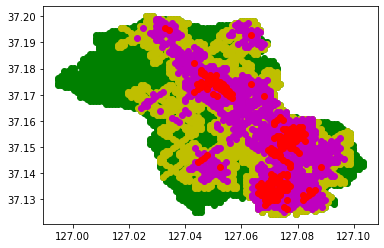

In [17]:
# 거리 가중치 부여 그래프로 확인
import matplotlib.pyplot as plt

is_10 = osanAccident['youchiwon'] > 15
result_10 = osanAccident[is_10]
print(len(result_10))

is_5 = osanAccident['youchiwon'] > 5
result_5 = osanAccident[is_5]
print(len(result_5))

is_1 = osanAccident['youchiwon'] > 0
result_1 = osanAccident[is_1]
print(len(result_1))

plt.plot(osanAccident['lonM'],osanAccident['latM'], 'go')
plt.plot(result_1['lonM'], result_1['latM'], 'yo')
plt.plot(result_5['lonM'], result_5['latM'], 'mo')
plt.plot(result_10['lonM'], result_10['latM'], 'ro')
plt.show()

In [18]:
# 3-3. 거리 의미 부여 - 초등학교

list_ele =  addDistanceW('elementry')
osanAccident = osanAccident.drop(columns=['elementry']) 
osanAccident['elementry'] = list_ele 


23


In [19]:
# 3-4. 거리 의미 부여 - 학원

list_aca =  addDistanceW('academy')
osanAccident = osanAccident.drop(columns=['academy']) 
osanAccident['academy'] = list_aca

154


In [20]:
# 3-5. 거리 의미 부여 - 체육시설

list_gym =  addDistanceW('gym')
osanAccident = osanAccident.drop(columns=['gym']) 
osanAccident['gym'] = list_gym

100


In [22]:
# 3-6. 거리 의미 부여 - 어린이 보호구역
# 반경 300m 이내, 누적 불가
is_cnt = osanAccident['school_zone'] == 1
cnt_df = osanAccident[is_cnt]
print(len(cnt_df))

lat100 = math.trunc((osanAccident['lat2'][0] - osanAccident['lat1'][0])*1000000000)
lon100 = math.trunc((osanAccident['lon2'][0] - osanAccident['lon1'][0])*1000000000)

lat_sqrt2 = math.trunc((osanAccident['lat2'][0] - osanAccident['lat1'][0])*math.sqrt(2)*1000000000)
lon_sqrt2 = math.trunc((osanAccident['lon2'][0] - osanAccident['lon1'][0])*math.sqrt(2)*1000000000)

a = 9061*5  # lat 오차범위 변수
b = 11204*5 # lon 오차범위 변수

# 격자간 100m 단위 좌표 단위 변경 (소수점 끌어올리기)
sosu = cnt_df.loc[:,['latM','lonM']]
org_sosu = osanAccident.loc[:,['latM','lonM']]

sosu.reset_index(drop=True, inplace=True)
sosu['latM']=(sosu['latM']-37)*1000000000
sosu['lonM']=(sosu['lonM']-126)*1000000000

org_sosu['latM']=(org_sosu['latM']-37)*1000000000
org_sosu['lonM']=(org_sosu['lonM']-126)*1000000000

list_cntW = [0 for i in range(len(osanAccident['id']))]

for i in range(len(org_sosu['latM'])):
    for k in range(len(sosu['latM'])):
        # 두 격자의 거리차, 소수점 버림으로 정수로 일괄 변경
        latA = abs(math.trunc(org_sosu['latM'][i]) - math.trunc(sosu['latM'][k]))
        lonA = abs(math.trunc(org_sosu['lonM'][i]) - math.trunc(sosu['lonM'][k]))
        
        # 중심으로 부터 300m 근방 격자 
        if lat100*2 - a < latA and latA <= lat_sqrt2*2+a and lon100*2 - b < lonA and lonA <= lon_sqrt2*2+b :
            list_cntW[i] = 1
        # 중심으로 부터 200m 근방 격자 
        elif lat100 - a < latA and latA <= lat_sqrt2+a and lon100 - b < lonA and lonA <= lon_sqrt2+b :
            list_cntW[i] = 1
        # 건물의 중심을 가지고 있는 격자 100m 
        elif latA <= a and lonA <= b :
            list_cntW[i] = 1
        else :
            pass

osanAccident = osanAccident.drop(columns=['school_zone']) 
osanAccident['school_zone'] = list_cntW

print(osanAccident['school_zone'].sum())
print(osanAccident.head())

85
641
   id  acc_sum        lon1       lat1        lon2       lat2  cctv  cross  \
0   0        0  126.994216  37.174182  126.995336  37.175089     0      0   
1   1        0  126.994210  37.175084  126.995330  37.175990     0      0   
2   2        0  126.994204  37.175985  126.995324  37.176891     0      0   
3   3        0  126.994198  37.176887  126.995318  37.177793     0      0   
4   4        0  126.995342  37.174187  126.996463  37.175093     0      0   

   speedBump  parking  ...  youth  baby  build       latM        lonM  \
0          0        0  ...    0.0   0.0    0.0  37.173729  126.994776   
1          0        0  ...    0.0   0.0    0.0  37.174631  126.994770   
2          0        0  ...    0.0   0.0    0.0  37.175532  126.994764   
3          0        0  ...    0.0   0.0    0.0  37.176433  126.994758   
4          0        0  ...    0.0   0.0    0.0  37.173734  126.995902   

   youchiwon  elementry  academy  gym  school_zone  
0          0          0        0    0 

In [23]:
# 4. 가중치 반영된 완성된 데이터 셋 저장
osanAccident.to_csv('ETL_DATA/OsanDataset.csv', index = False)